In [18]:
# for each baseline model of number of iterations X
# put its performance in the middle as a bar.
# then, put models leD1, leD2 ... ,leD{X-1} on its left.
# put models geD2, geD3, ..., geD{X} to its right.

# remember, only consider those models that have all variants (original + all leD + all geD) available.

from os.path import join
from os import makedirs
from thesis_v2 import dir_dict
from thesis_v2.plots.util import savefig

In [19]:
from thesis_v2.plots.main_results_tables import mean_generalized
from functools import partial

In [20]:
import pandas as pd
import numpy as np

In [21]:
def get_normalized_vec(x):
#     keys = [('I',) + ('B1',) + ('R1',)*i for i in range(7)]
#     assert x.keys() <= set(keys)
    ret = np.zeros((8,))
    for key, v in x.items():
        assert (len(key) >= 2 and len(key) <= 9), key
        ret[len(key)-2] += v  # -2 because minimal length of key is 2 (I + one Conv)
    ret = ret/ret.sum()
    return ret

def get_weighted_avg(x):
    assert x.ndim == 1 and x.shape == (8,) and np.all(x >= 0)
    return np.average(np.arange(8), weights=x)

In [22]:
def load_original_df():
    f_main_result = join(dir_dict['analyses'], 'tang_refactored', '20201218', 'main_result.pkl')
    dir_plot = join(dir_dict['plots'], 'tang_refactored', '20201218')
    makedirs(dir_plot, exist_ok=True)
    df_main_result = pd.read_pickle(f_main_result).sort_index()
    assert df_main_result.index.is_unique
    
    f_main_result_src = join(dir_dict['analyses'], 'tang_refactored', '20201218', 'source_analysis.pkl')
    df_main_result_src = pd.read_pickle(f_main_result_src).sort_index()
    assert df_main_result_src.index.is_unique
    df_main_result_src = df_main_result_src.dropna()
    
    df_main_result_src['source_analysis_vec'] = df_main_result_src['source_analysis'].map(lambda x: get_normalized_vec(x))
    df_main_result_src['source_analysis_scalar'] = df_main_result_src['source_analysis_vec'].map(lambda x: get_weighted_avg(x))
    
    return df_main_result.join(df_main_result_src[['source_analysis_scalar','source_analysis_vec']],how='left',)

original_df = load_original_df()

In [23]:
f_main_result = join(dir_dict['analyses'], 'tang_refactored', '20201221', 'main_result.pkl')
dir_plot = join(dir_dict['plots'], 'tang_refactored', '20201221')
makedirs(dir_plot, exist_ok=True)
df_main_result = pd.read_pickle(f_main_result).sort_index()
assert df_main_result.index.is_unique

In [24]:
df_main_result

cc2_normed_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     False                mse       0          onlyD1          2         16          2           cm-avg       1400              0.428682   
                                                                                                     cm-last      1400              0.431366   
                                                                                                     inst-avg     1400              0.428557   
                                                                                                     inst-last    1400              0.430426   
                                                                                         3           cm-avg       1400              0.424862   
...                                                                                                                                      ...   
softplus True                 poisson   1          onlyD7          2         16          7           inst-last    1400              0.461435   
                                                                             32          7           cm-avg       1400              0.452641   
                                                                                                     cm-last      1400              0.452641   
                                                                                                     inst-avg     1400              0.452641   
                                                                                                     inst-last    1400              0.452641   

                                                                                                                              cc2_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep                
relu     False                mse       0          onlyD1          2         16          2           cm-avg       1400           0.398260   
                                                                                                     cm-last      1400           0.400550   
                                                                                                     inst-avg     1400           0.398116   
                                                                                                     inst-last    1400           0.400123   
                                                                                         3           cm-avg       1400           0.394700   
...                                                                                                                                   ...   
softplus True                 poisson   1          onlyD7          2         16          7           inst-last    1400           0.427977   
                                                                             32          7           cm-avg       1400           0.419522   
                                                                                                     cm-last      1400           0.419522   
                                                                                                     inst-avg     1400           0.419522   
                                                                                                     inst-last    1400           0.419522   

                                                                                                                              cc_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed multi_path_hack num_layer out_channel rcnn_bl_cls readout_type train_keep               
relu     False                mse       0          onlyD1          2         16          2           cm-avg       1400          0.607833   

In [25]:
# load source analysis results
def load_source_analysis():
    f_main_result_src = join(dir_dict['analyses'], 'tang_refactored', '20201221', 'source_analysis.pkl')
    df_main_result_src = pd.read_pickle(f_main_result_src).sort_index()
    assert df_main_result_src.index.is_unique
    df_main_result_src = df_main_result_src.dropna()
    
    df_main_result_src['source_analysis_vec'] = df_main_result_src['source_analysis'].map(lambda x: get_normalized_vec(x))
    df_main_result_src['source_analysis_scalar'] = df_main_result_src['source_analysis_vec'].map(lambda x: get_weighted_avg(x))
    
    return df_main_result_src

df_src = load_source_analysis()

In [26]:
def get_geD1_perf(perf):
    ret = perf.xs('geD1', level='multi_path_hack')
    return ret.sort_index().rename('geD1')

def get_leDX_perf(perf):
    ret = perf[
        perf.index.get_level_values(
            'multi_path_hack'
            # here .values is important. otherwise this code does not work properly. not sure why.
            # pandas is complicated.
        ).map(lambda x: x.startswith('leD')).values & (
             perf.index.get_level_values('multi_path_hack').map(lambda x: int(x[3:])) ==  perf.index.get_level_values('rcnn_bl_cls')
        )
    ]
                                                                                             
    return ret.droplevel('multi_path_hack').sort_index().rename('leDX')


In [27]:
def get_original_perf(ref_perf, perf_column, read_depth):
    if not read_depth:
        ret = pd.concat(
        [
            pd.read_pickle(join(dir_dict['analyses'], 'tang_refactored', '20201215', 'main_result_separatebn.pkl')),
        ], axis=0
    ).dropna()[perf_column]
    else:
        # load source analysis code.
        ret = pd.read_pickle(join(dir_dict['analyses'], 'tang_refactored', '20201215', 'source_analysis.pkl'))
        ret = ret.dropna()
        ret = ret[ret.index.get_level_values('rcnn_bl_cls')<=7]
        ret['source_analysis_vec'] = ret['source_analysis'].map(lambda x: get_normalized_vec(x))
        ret['source_analysis_scalar'] = ret['source_analysis_vec'].map(lambda x: get_weighted_avg(x))
        ret = ret[perf_column]
        
    index = ref_perf.xs('geD1', level='multi_path_hack').index
    assert index.names == ret.index.names
    return ret[index].sort_index().rename('original')

In [28]:
def get_baseline_perf(*, perf_col, read_depth):
    df = original_df
    # this is average of geD1, leDX, as well as original models trained in 20201114+20201118.
    perf = df[perf_col]
    df1 = get_geD1_perf(perf)
    df2 = get_leDX_perf(perf)
    df3 = get_original_perf(perf, perf_col, read_depth=read_depth)
    assert df1.index.equals(df2.index)
    assert df1.index.equals(df3.index)
    
    assert df1.shape == df2.shape == df3.shape == (384*2,)
    
    # take average
    merged = pd.concat([df1, df2, df3], axis=1)
    return merged.apply(func=partial(mean_generalized, drop_na=True), axis=1).dropna()

In [29]:
def main_loop(df, *, perf_col='cc2_normed_avg', source_analysis_col='source_analysis_scalar', source_analysis_vec_col='source_analysis_vec'):
    baseline_perf = get_baseline_perf(perf_col=perf_col, read_depth=False)
    # cycle over different readout_type, and num_channel
    index_num_layer = baseline_perf.index.get_level_values('num_layer').values
    index_out_channel = baseline_perf.index.get_level_values('out_channel').values
    index_readout_type = baseline_perf.index.get_level_values('readout_type').values

    index_layer_ch_readout = np.asarray(
        [index_num_layer, index_out_channel, index_readout_type]
    ).T.tolist()
    index_layer_ch_readout = [tuple(x) for x in index_layer_ch_readout]
    # np.unique does not work, because index_readout_type here is of `object` dtype. too generic for numpy
    # TypeError: The axis argument to unique is not supported for dtype object
    unique_layer_ch_readout = sorted(set(index_layer_ch_readout))
    perf_all=df[perf_col]
    
    depth_baseline = get_baseline_perf(perf_col=source_analysis_col, read_depth=True)
    depth_all = df[source_analysis_col]
    
    
    depth_vec_baseline = get_baseline_perf(perf_col=source_analysis_vec_col, read_depth=True)
    depth_vec_all = df[source_analysis_vec_col]
    
    for key_this in unique_layer_ch_readout:

        num_l, num_ch, readout = key_this
        print(key_this)
        inner_loop(
            perf_all=perf_all, perf_baseline=baseline_perf,
            num_l = num_l, num_ch = num_ch, readout = readout,
            depth_baseline=depth_baseline,depth_all=depth_all,
            depth_vec_baseline=depth_vec_baseline,depth_vec_all=depth_vec_all,
        )
    print('overall')
    inner_loop(
            perf_all=perf_all, perf_baseline=baseline_perf,
            num_l = None, num_ch = None, readout = None,
            depth_baseline=depth_baseline,depth_all=depth_all,
            depth_vec_baseline=depth_vec_baseline,depth_vec_all=depth_vec_all,
    )

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
from scipy.stats import sem

In [32]:
def plt_vec_bars_inner(ax, data_mean, data_std):
    ax.bar(x=np.arange(1,9), height=data_mean, yerr=data_std)
    ax.set_ylim(0, 1.0)

In [35]:
def inner_loop(
    *,
    perf_all, perf_baseline,
    num_l, num_ch, readout,
    depth_all, depth_baseline,
    depth_vec_all, depth_vec_baseline,
):
    # first, get all baseline models in this case
    
    if num_l is None and num_ch is None and readout is None:
        perf_baseline_this = perf_baseline
        perf_all_this = perf_all
        suffix = 'all'
        depth_all_this = depth_all
        depth_baseline_this = depth_baseline
        depth_vec_all_this = depth_vec_all
        depth_vec_baseline_this = depth_vec_baseline
    else:
        assert num_l is not None and num_ch is not None and readout is not None
        perf_baseline_this = perf_baseline.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )

        perf_all_this = perf_all.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )
        
        depth_baseline_this = depth_baseline.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )

        depth_all_this = depth_all.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )
        
        depth_vec_baseline_this = depth_vec_baseline.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )

        depth_vec_all_this = depth_vec_all.xs(
            key=(num_l, num_ch, readout), level=('num_layer', 'out_channel', 'readout_type')
        )
        
        suffix = f'l{num_l},ch{num_ch},{readout}'

    print(
        perf_baseline_this.shape, perf_all_this.shape, depth_baseline_this.shape, depth_all_this.shape,
        depth_vec_baseline_this.shape, depth_vec_all_this.shape
    )
    
    inner_loop_helper(
        perf_baseline_this=perf_baseline_this,
        perf_all_this=perf_all_this, suffix=suffix,
        depth_baseline_this=depth_baseline_this,
        depth_all_this=depth_all_this,
        depth_vec_baseline_this=depth_vec_baseline_this,
        depth_vec_all_this=depth_vec_all_this,
    )
    
    

def plot_one_curve(*, ax, perf_baseline_this, perf_all_this, relative, plot_distribution=False):
    
    unique_cls = perf_baseline_this.index.get_level_values('rcnn_bl_cls').unique()
    assert np.array_equal(unique_cls, np.arange(2, unique_cls[-1]+1))
    max_cls = unique_cls[-1]
    
    data_all = []
    
    if plot_distribution:
        assert relative is None
    # if plot_distribution, ax should be a grid.
        assert ax.shape == (max_cls-1, 2*max_cls+1)
    
    for cls_idx, cls_this in enumerate(unique_cls):
        # get all models
        perf_baseline_this_cls = perf_baseline_this.xs(cls_this, level='rcnn_bl_cls').sort_index()
        
        # get all models in this cls, all
        perf_all_this_cls = perf_all_this.xs(cls_this, level='rcnn_bl_cls')
        
        # put models leD1, leD2 ... ,leD{X-1} on its left.
        # put models geD2, geD3, ..., geD{X} to its right.
        
        data_all_to_plot_mean = []
        data_all_to_plot_err = []
        
        for d_lower in range(1, cls_this+1)[::-1]:
            data_this = inner_loop_helper_inner(
                perf_baseline_this_cls=perf_baseline_this_cls,
                perf_all_this_cls=perf_all_this_cls,
                spec=f'onlyD{d_lower}'
            )
            data_all_to_plot_mean.append(data_this['mean'])
            # sem typically gives better results.
            data_all_to_plot_err.append(data_this['sem'])
            data_all.append(data_this)

        
        # plot itself.
        data_this_base = inner_loop_helper_inner(
            perf_baseline_this_cls=perf_baseline_this_cls,
            perf_all_this_cls=perf_all_this_cls,
            spec=None,
        )
        data_all_to_plot_mean.append(data_this_base['mean'])
        data_all_to_plot_err.append(data_this_base['sem'])
#         data_all.append(data_this_base)
        
        for d_higher in range(1, cls_this+1):
            data_this = inner_loop_helper_inner(
                perf_baseline_this_cls=perf_baseline_this_cls,
                perf_all_this_cls=perf_all_this_cls,
                spec=f'onlyD{d_higher}'
            )
            data_all_to_plot_mean.append(data_this['mean'])
            # sem typically gives better results.
            data_all_to_plot_err.append(data_this['sem'])
            data_all.append(data_this)
        assert len(data_all_to_plot_mean) == len(data_all_to_plot_err) == 2*cls_this + 1
        
        offset = max_cls - cls_this
        
        if not plot_distribution:
        
            # so that every one has original perf in the middle.
            ax.errorbar(
                x=np.arange(2*cls_this + 1) + offset,
                y=(np.array(data_all_to_plot_mean)-data_this_base['mean'] if relative else np.array(data_all_to_plot_mean)),
                       yerr=np.array(data_all_to_plot_err
                                    ), label=str(cls_this))
        else:
            
            for bar_idx, (bar_mean, bar_sem) in enumerate(zip(data_all_to_plot_mean, data_all_to_plot_err)):
                # plot one distribution plus sem
                ax_this = ax[cls_idx, offset+bar_idx]
                assert bar_mean.shape == bar_sem.shape == (8,)
                plt_vec_bars_inner(ax_this, bar_mean, bar_sem)
                
    
    
    if not plot_distribution:
        ax.legend(loc='best', title='number of iterations T')

        if relative:
            ax.set_ylabel('''$\\Delta$ of average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$''')
        else:
            ax.set_ylabel('''Average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$''')

        ax.set_xticks(np.arange(2*(max_cls) + 1))
        ax.set_xticklabels(
            # TODO: fix this for num_layer = 3 models.
            [f'|p| ≤ T-{d_lower}' for d_lower in range(1, max_cls+1)[::-1]] + 
            ['|p| = 1,...,T'] + 
            [f'|p| ≥ {d_higher}' for d_higher in range(1, cls_this+1)], rotation=45
        )
        if relative:
            ax.axhline(y=0,color='k',linestyle='--')
    return data_all
    
def inner_loop_helper(
    *,
    perf_baseline_this, perf_all_this, suffix,
    depth_baseline_this, depth_all_this,
    depth_vec_all_this, depth_vec_baseline_this,
):
    # ok.
    # get all cls
    
    
    plt.close('all')
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
    axes = axes.ravel()
    
    plot_one_curve(ax=axes[0], perf_baseline_this=perf_baseline_this, perf_all_this=perf_all_this,relative=False)
    abs_perf_all = plot_one_curve(ax=axes[1], perf_baseline_this=perf_baseline_this, perf_all_this=perf_all_this,relative=True)
    
    
    
    fig.subplots_adjust(left=0.1, right=0.975, bottom=0.175, top=0.95, wspace=0.2, hspace=0.2)
    fig.suptitle(f'performance change of keeping only paths of certain length |p|, over {perf_baseline_this.size} full models')
    savefig(fig, join(dir_plot, f'both_perf_change_2l_{suffix}.pdf'))
    plt.show()
    
    # model depth curve.
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 5), squeeze=True)
    abs_depth_all = plot_one_curve(ax=ax, perf_baseline_this=depth_baseline_this, perf_all_this=depth_all_this,relative=False)
    savefig(fig, join(dir_plot, f'depth_2l_{suffix}.pdf'))
    plt.show()
    
    
    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 5), squeeze=True)
    aaaa = [x['mean'] for x in abs_perf_all]
    bbbb = [x['mean'] for x in abs_depth_all]
    print(aaaa, bbbb)
    ax.scatter(aaaa, bbbb)
    plt.show()
    
    # plot vecs
    plt.close('all')
    fig, axes = plt.subplots(nrows=6, ncols=15,figsize=(20, 8), squeeze=False)
    axes = axes[::-1]
    plot_one_curve(
        ax=axes, 
        perf_baseline_this=depth_vec_baseline_this, 
        perf_all_this=depth_vec_all_this,
        relative=None,
        plot_distribution=True,
    )
    plt.show()
    
    
    
def inner_loop_helper_inner(
    *,
    perf_baseline_this_cls,
    perf_all_this_cls,
    spec,
    
):
    if spec is None:
        data = perf_baseline_this_cls
    else:
        data = perf_all_this_cls.xs(spec, level='multi_path_hack').dropna().sort_index()
    assert perf_baseline_this_cls.index.isin(data.index).all(), perf_baseline_this_cls.index.isin(data.index).mean()
    data = data[perf_baseline_this_cls.index]
    assert data.shape == perf_baseline_this_cls.shape

    return {
        # for generalization
        'mean': np.asarray(data.values.tolist()).mean(axis=0),
        'std': np.asarray(data.values.tolist()).std(axis=0),
        'sem': sem(np.asarray(data.values.tolist()),ddof=0,axis=0),
        'raw': data.values,
    }

(2, 16, 'cm-avg')
(96,) (432,) (96,) (432,) (96,) (432,)


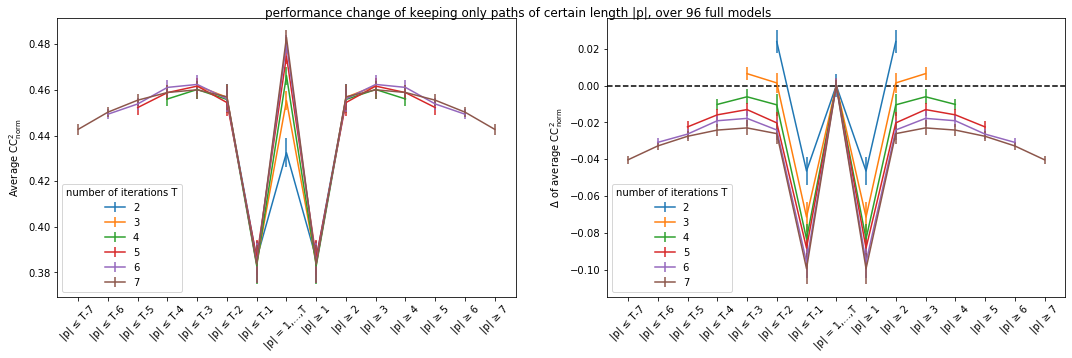

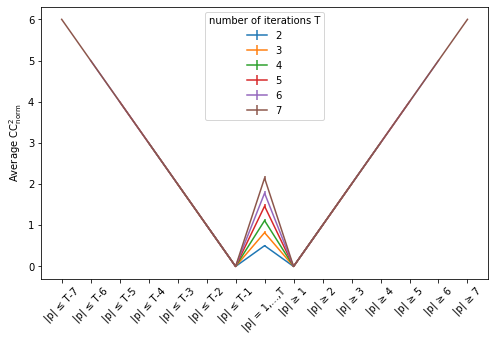

[0.4563448066229745, 0.3860636205890803, 0.3860636205890803, 0.4563448066229745, 0.4617976353737145, 0.4567458146150888, 0.3838927824243631, 0.3838927824243631, 0.4567458146150888, 0.4617976353737145, 0.45601239945971495, 0.46016289119829146, 0.4557886728318927, 0.38296113082213645, 0.38296113082213645, 0.4557886728318927, 0.46016289119829146, 0.45601239945971495, 0.4522459633754154, 0.4588031719235489, 0.46165292267292274, 0.45444234698747493, 0.38642240215398094, 0.38642240215398094, 0.45444234698747493, 0.46165292267292274, 0.4588031719235489, 0.4522459633754154, 0.4493458121861261, 0.4538379556892019, 0.46108981721926023, 0.46238278731292315, 0.45607907830760286, 0.3842009745195031, 0.3842009745195031, 0.45607907830760286, 0.46238278731292315, 0.46108981721926023, 0.4538379556892019, 0.4493458121861261, 0.442709730371172, 0.45024532500676445, 0.45548412809387406, 0.45886123858992867, 0.4600341608979961, 0.45692900516681445, 0.38355858030752726, 0.38355858030752726, 0.45692900516681

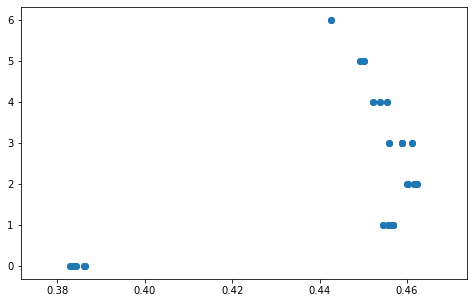

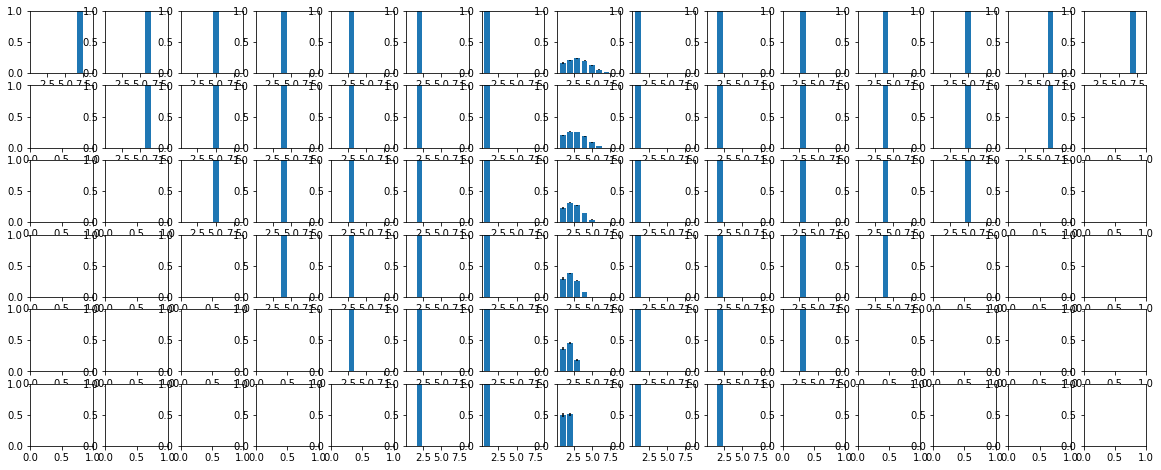

(2, 16, 'cm-last')
(96,) (432,) (96,) (432,) (96,) (432,)


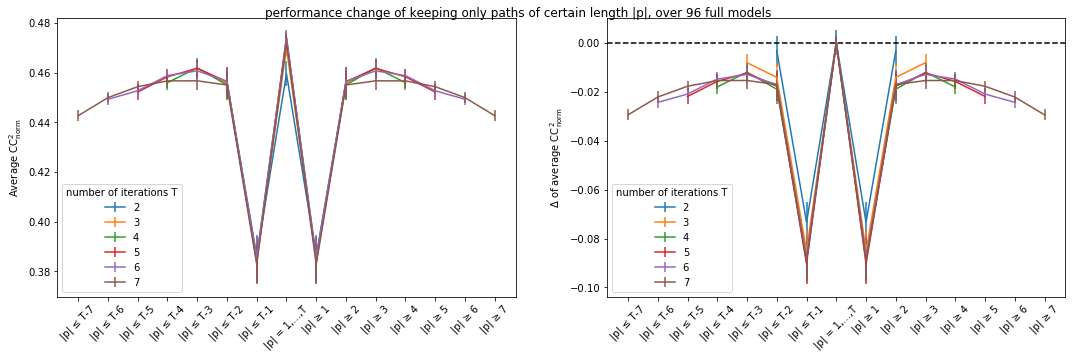

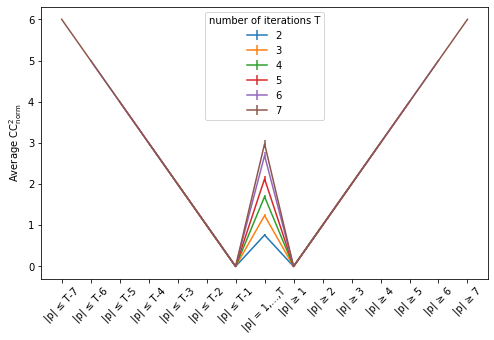

[0.4563448066229745, 0.3862675200734348, 0.3862675200734348, 0.4563448066229745, 0.4617976353737145, 0.45579419961276463, 0.3848235283551536, 0.3848235283551536, 0.45579419961276463, 0.4617976353737145, 0.45601239945971495, 0.46201052898080186, 0.4550739357867121, 0.3854336690329716, 0.3854336690329716, 0.4550739357867121, 0.46201052898080186, 0.45601239945971495, 0.4522459633754154, 0.4583845476976911, 0.46180854721139797, 0.4564256376716355, 0.3837756300478099, 0.3837756300478099, 0.4564256376716355, 0.46180854721139797, 0.4583845476976911, 0.4522459633754154, 0.4493458121861261, 0.45275590374678426, 0.4588630471744137, 0.46079332821921004, 0.4565788924362274, 0.3856107830401684, 0.3856107830401684, 0.4565788924362274, 0.46079332821921004, 0.4588630471744137, 0.45275590374678426, 0.4493458121861261, 0.442709730371172, 0.44999990291016134, 0.4544059397943395, 0.45673685092998084, 0.4567652328680817, 0.45508695114387554, 0.3828714433829462, 0.3828714433829462, 0.45508695114387554, 0.45

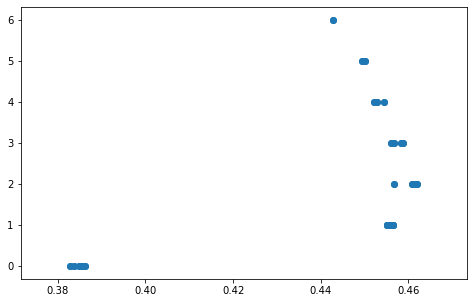

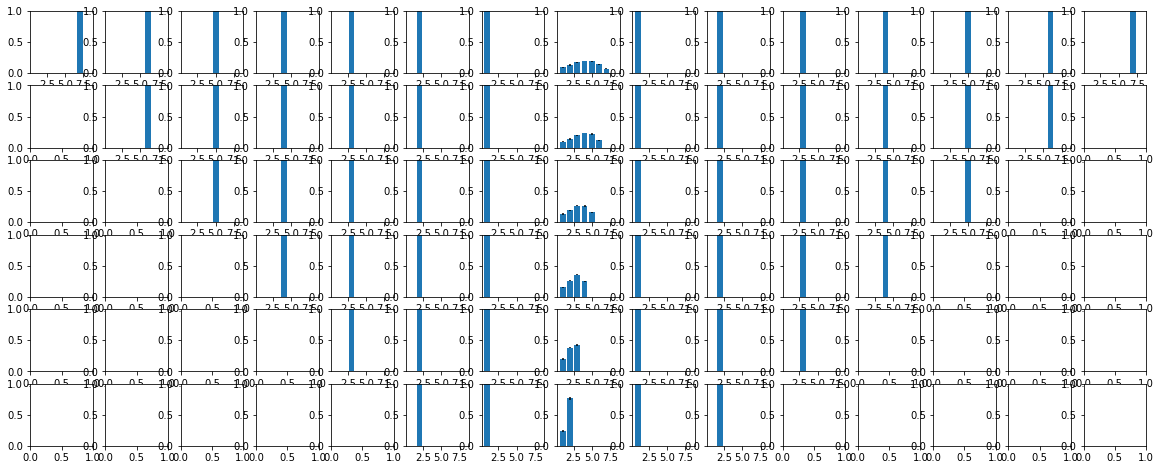

(2, 16, 'inst-avg')
(96,) (432,) (96,) (432,) (96,) (432,)


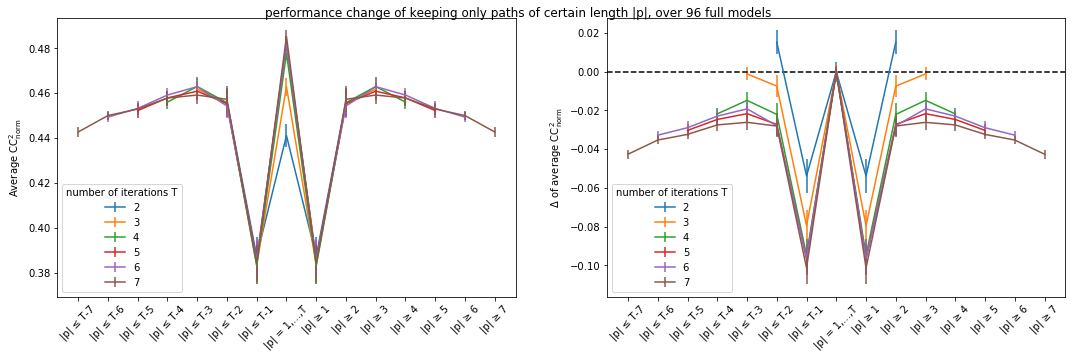

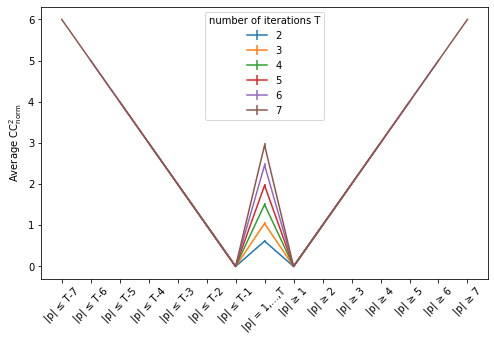

[0.4563448066229745, 0.3873084040126425, 0.3873084040126425, 0.4563448066229745, 0.4617976353737145, 0.45548783200573906, 0.3834478791120861, 0.3834478791120861, 0.45548783200573906, 0.4617976353737145, 0.45601239945971495, 0.4629722557786268, 0.45573509763621056, 0.38306064329249395, 0.38306064329249395, 0.45573509763621056, 0.4629722557786268, 0.45601239945971495, 0.4522459633754154, 0.4578956267077644, 0.4608787330291572, 0.45533777057346836, 0.38578203338163375, 0.38578203338163375, 0.45533777057346836, 0.4608787330291572, 0.4578956267077644, 0.4522459633754154, 0.4493458121861261, 0.4531979571145709, 0.459174181527757, 0.4629152191763225, 0.45427258088130396, 0.385789228202301, 0.385789228202301, 0.45427258088130396, 0.4629152191763225, 0.459174181527757, 0.4531979571145709, 0.4493458121861261, 0.442709730371172, 0.4500271472441296, 0.4529391276104764, 0.45783115502913463, 0.4591654014920492, 0.4572617995898792, 0.38403816525617346, 0.38403816525617346, 0.4572617995898792, 0.45916

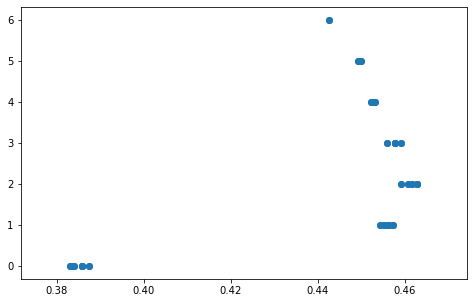

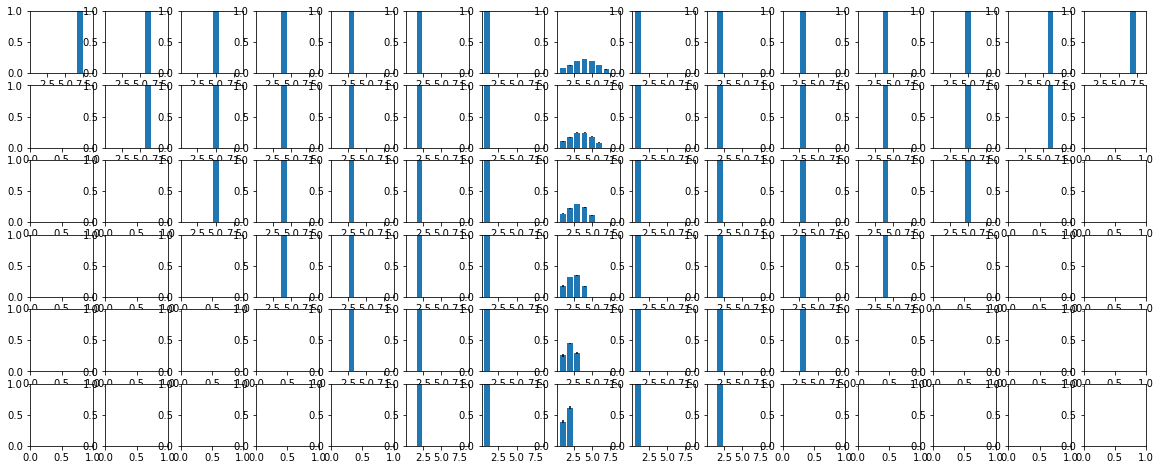

(2, 16, 'inst-last')
(96,) (432,) (96,) (432,) (96,) (432,)


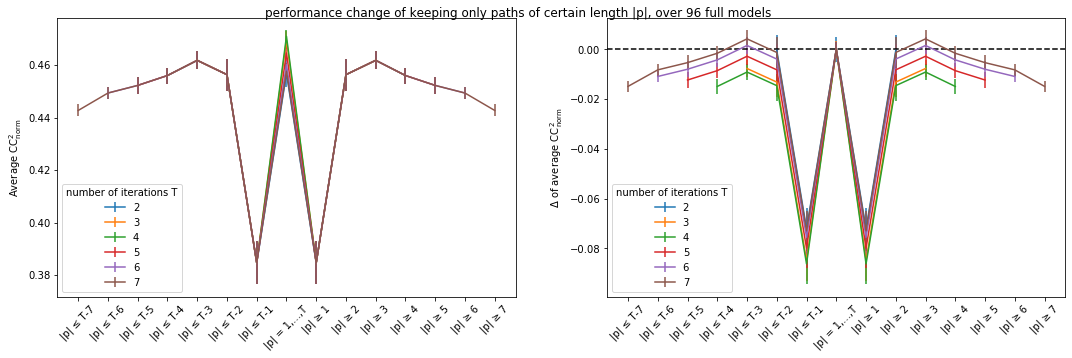

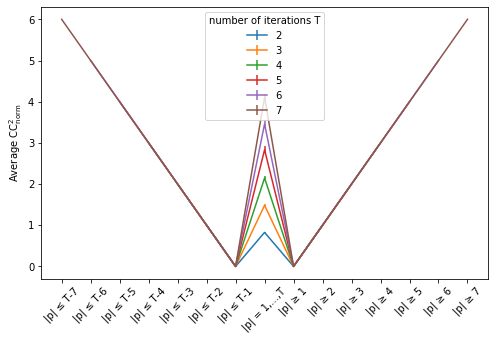

[0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0.4617976353737145, 0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0.4617976353737145, 0.45601239945971495, 0.4617976353737145, 0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0.4617976353737145, 0.45601239945971495, 0.4522459633754154, 0.45601239945971495, 0.4617976353737145, 0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0.4617976353737145, 0.45601239945971495, 0.4522459633754154, 0.4493458121861261, 0.4522459633754154, 0.45601239945971495, 0.4617976353737145, 0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0.4617976353737145, 0.45601239945971495, 0.4522459633754154, 0.4493458121861261, 0.442709730371172, 0.4493458121861261, 0.4522459633754154, 0.45601239945971495, 0.4617976353737145, 0.4563448066229745, 0.38471095731928684, 0.38471095731928684, 0.4563448066229745, 0

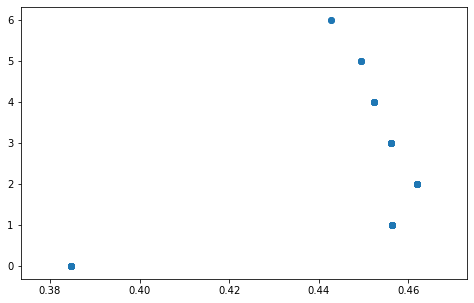

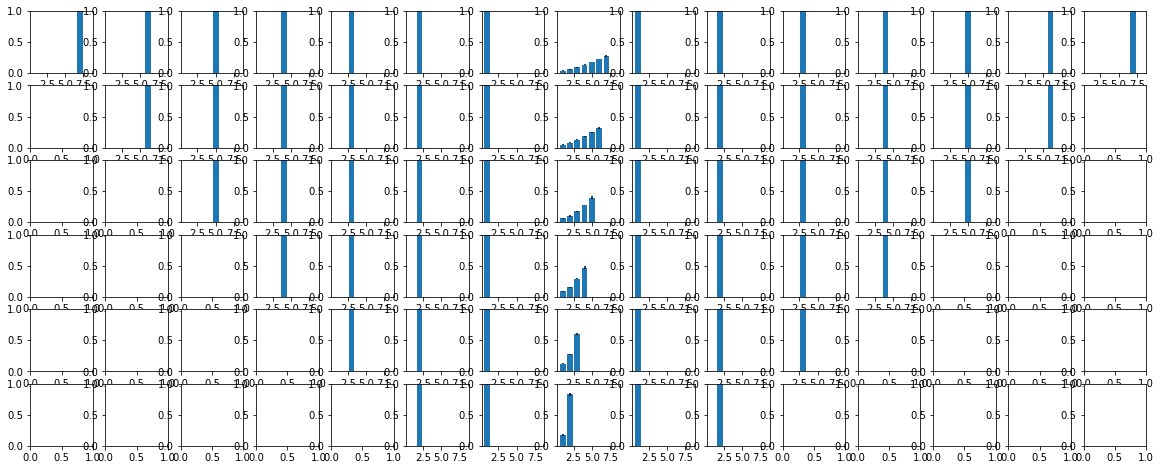

(2, 32, 'cm-avg')
(96,) (432,) (96,) (432,) (96,) (432,)


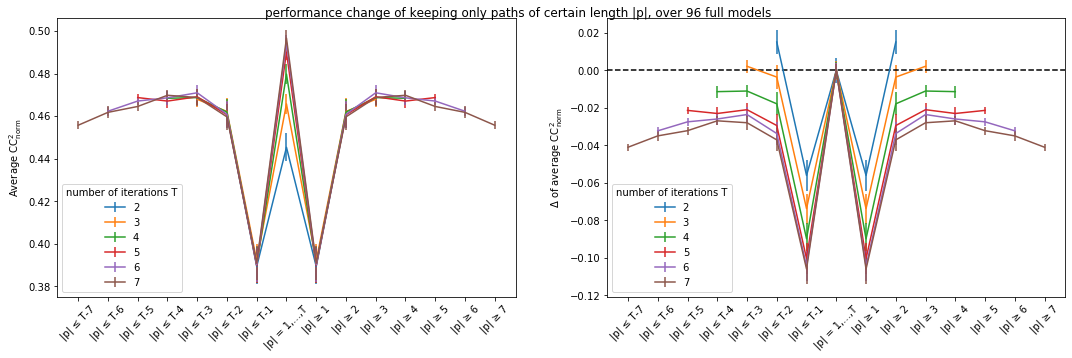

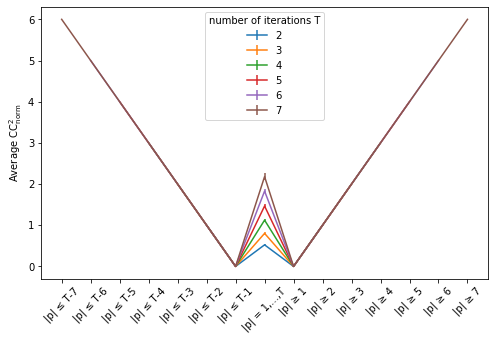

[0.46050752765641767, 0.3893660736562573, 0.3893660736562573, 0.46050752765641767, 0.46798459287939664, 0.4622232532962848, 0.39206949359633536, 0.39206949359633536, 0.4622232532962848, 0.46798459287939664, 0.46847049449055667, 0.4687949818064756, 0.46197310236929756, 0.39004012255916076, 0.39004012255916076, 0.46197310236929756, 0.4687949818064756, 0.46847049449055667, 0.4687964440576947, 0.46714996220594956, 0.4691693505727109, 0.46072609293673195, 0.3897846242757882, 0.3897846242757882, 0.46072609293673195, 0.4691693505727109, 0.46714996220594956, 0.4687964440576947, 0.4623693936356881, 0.46716031166428906, 0.46868086379811336, 0.4710488049588015, 0.4609258654006612, 0.3901317776367983, 0.3901317776367983, 0.4609258654006612, 0.4710488049588015, 0.46868086379811336, 0.46716031166428906, 0.4623693936356881, 0.45578469360782997, 0.46184189666985304, 0.46461161313094385, 0.46987011259694117, 0.4688475733410282, 0.45971050668023206, 0.39085809151119916, 0.39085809151119916, 0.4597105066

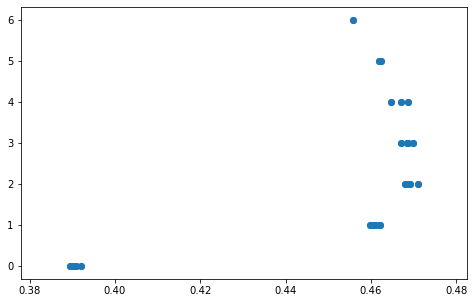

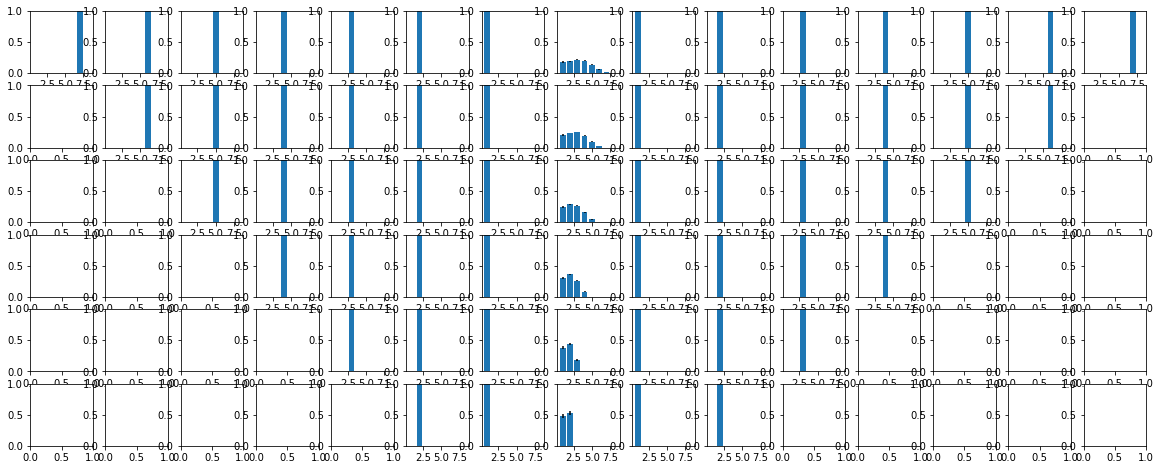

(2, 32, 'cm-last')
(96,) (432,) (96,) (432,) (96,) (432,)


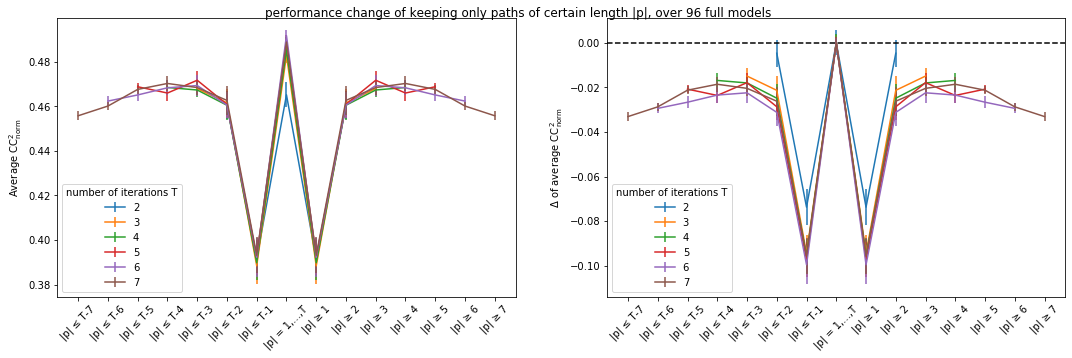

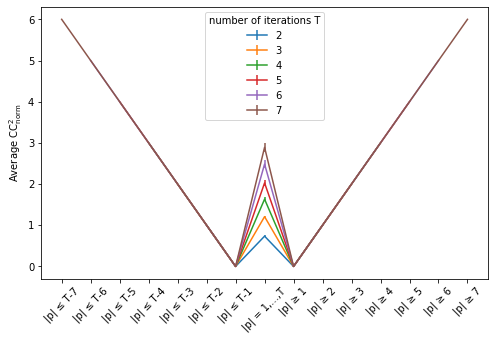

[0.46050752765641767, 0.3914875761226395, 0.3914875761226395, 0.46050752765641767, 0.46798459287939664, 0.46158656601497616, 0.3884343529444015, 0.3884343529444015, 0.46158656601497616, 0.46798459287939664, 0.46847049449055667, 0.46734162647524213, 0.4605057053062168, 0.3897983824398529, 0.3897983824398529, 0.4605057053062168, 0.46734162647524213, 0.46847049449055667, 0.4687964440576947, 0.4659783495724107, 0.4717150283287204, 0.46089552704722647, 0.3923530333119172, 0.3923530333119172, 0.46089552704722647, 0.4717150283287204, 0.4659783495724107, 0.4687964440576947, 0.4623693936356881, 0.4651234086579077, 0.4683230801772229, 0.469339014375895, 0.460567135376015, 0.39224176073810424, 0.39224176073810424, 0.460567135376015, 0.469339014375895, 0.4683230801772229, 0.4651234086579077, 0.4623693936356881, 0.45578469360782997, 0.4601437493257825, 0.4676137186288068, 0.4702711588562277, 0.46843661596285335, 0.462674919845925, 0.3931806089927099, 0.3931806089927099, 0.462674919845925, 0.4684366

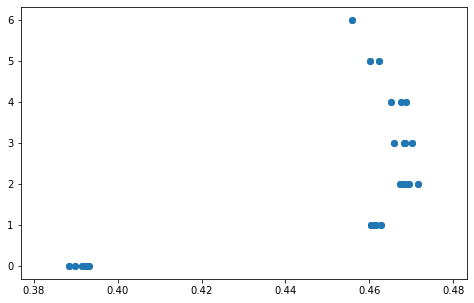

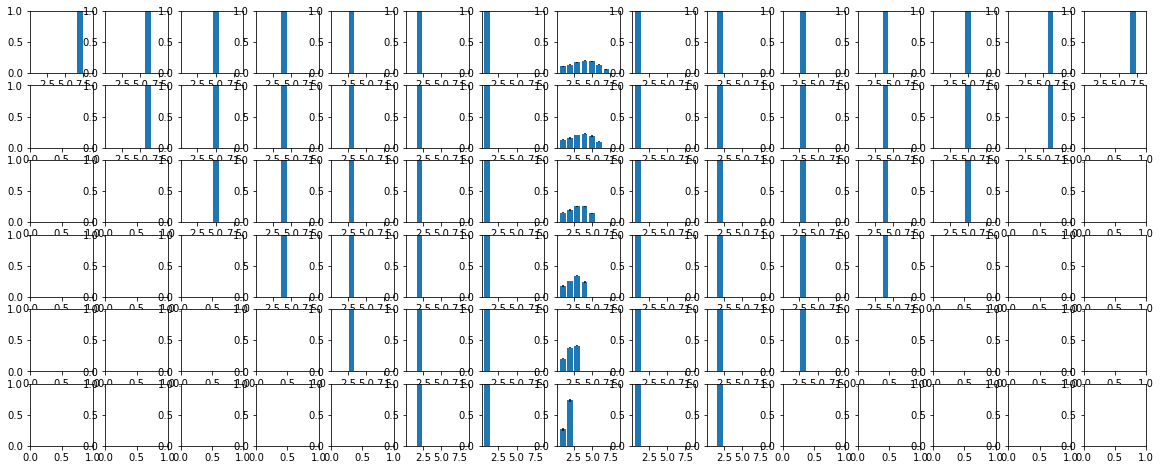

(2, 32, 'inst-avg')
(96,) (432,) (96,) (432,) (96,) (432,)


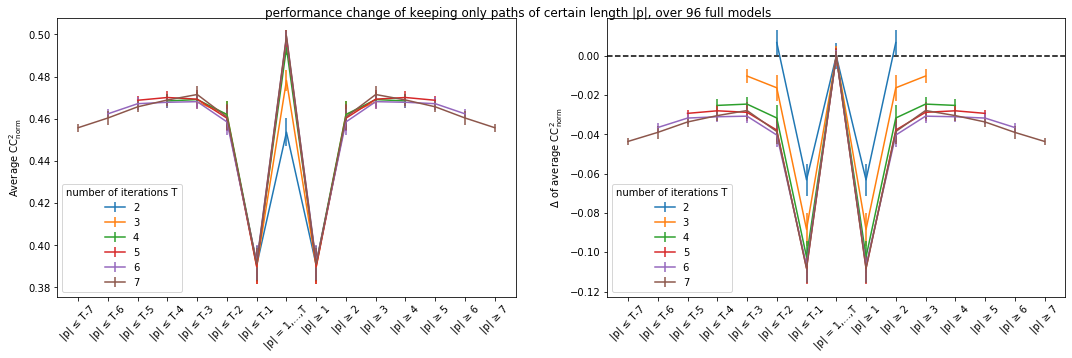

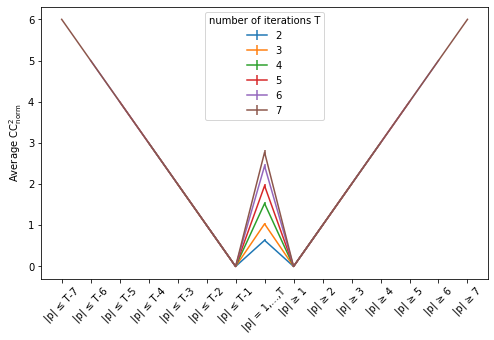

[0.46050752765641767, 0.3905761518937917, 0.3905761518937917, 0.46050752765641767, 0.46798459287939664, 0.46198931336131077, 0.38985291149310247, 0.38985291149310247, 0.46198931336131077, 0.46798459287939664, 0.46847049449055667, 0.4691331724676746, 0.46206336336883513, 0.3912787476886519, 0.3912787476886519, 0.46206336336883513, 0.4691331724676746, 0.46847049449055667, 0.4687964440576947, 0.4701064922633425, 0.46932876560375825, 0.46029598078846307, 0.38987058433643706, 0.38987058433643706, 0.46029598078846307, 0.46932876560375825, 0.4701064922633425, 0.4687964440576947, 0.4623693936356881, 0.4671729135892068, 0.4678434950658643, 0.46813801735468613, 0.45853022630810514, 0.39192438477986985, 0.39192438477986985, 0.45853022630810514, 0.46813801735468613, 0.4678434950658643, 0.4671729135892068, 0.4623693936356881, 0.45578469360782997, 0.4603936749963523, 0.4656953981477183, 0.4689352637543871, 0.47152566825318937, 0.46083455569385784, 0.3911049944727109, 0.3911049944727109, 0.4608345556

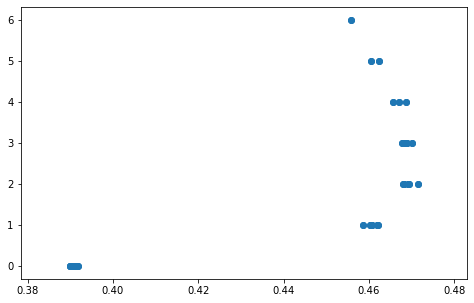

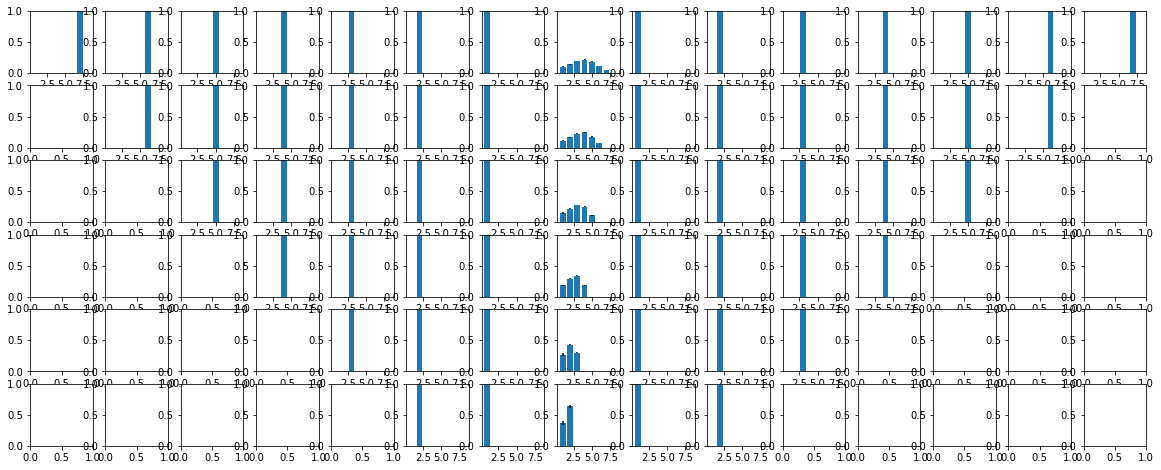

(2, 32, 'inst-last')
(96,) (432,) (96,) (432,) (96,) (432,)


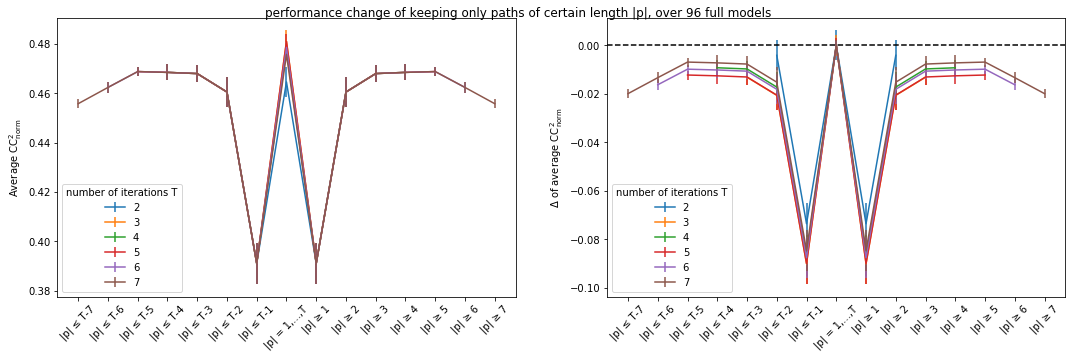

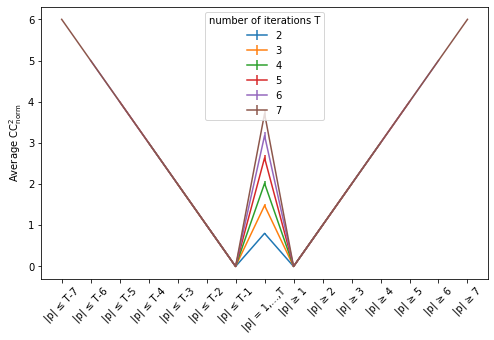

[0.46050752765641767, 0.39108252050502035, 0.39108252050502035, 0.46050752765641767, 0.46798459287939664, 0.46050752765641767, 0.39108252050502035, 0.39108252050502035, 0.46050752765641767, 0.46798459287939664, 0.46847049449055667, 0.46798459287939664, 0.46050752765641767, 0.39108252050502035, 0.39108252050502035, 0.46050752765641767, 0.46798459287939664, 0.46847049449055667, 0.4687964440576947, 0.46847049449055667, 0.46798459287939664, 0.46050752765641767, 0.39108252050502035, 0.39108252050502035, 0.46050752765641767, 0.46798459287939664, 0.46847049449055667, 0.4687964440576947, 0.4623693936356881, 0.4687964440576947, 0.46847049449055667, 0.46798459287939664, 0.46050752765641767, 0.39108252050502035, 0.39108252050502035, 0.46050752765641767, 0.46798459287939664, 0.46847049449055667, 0.4687964440576947, 0.4623693936356881, 0.45578469360782997, 0.4623693936356881, 0.4687964440576947, 0.46847049449055667, 0.46798459287939664, 0.46050752765641767, 0.39108252050502035, 0.39108252050502035,

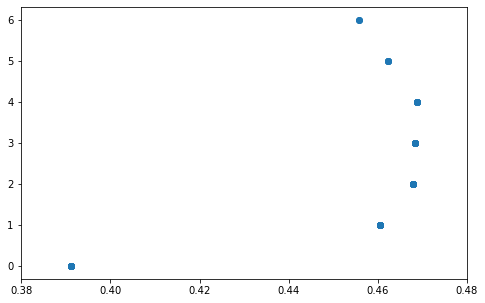

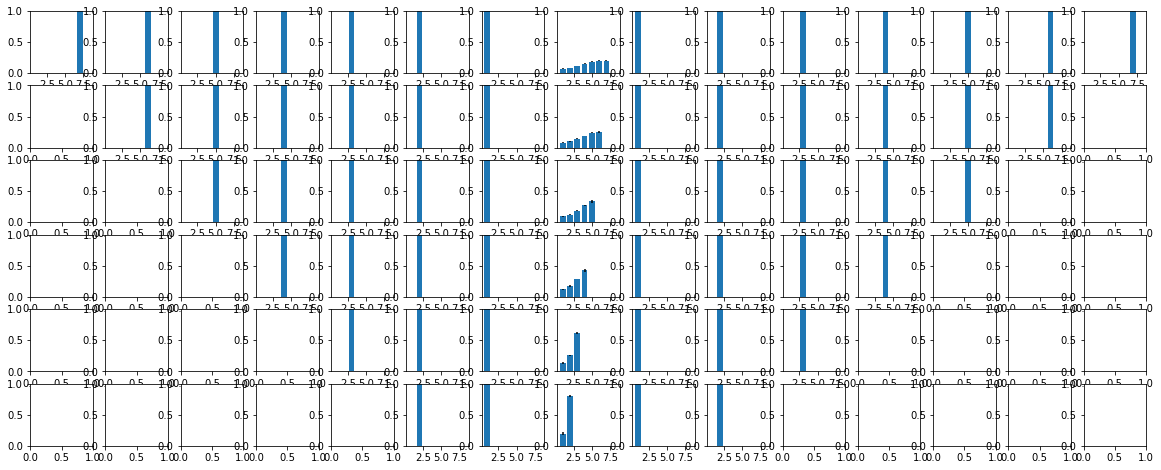

overall
(768,) (3456,) (768,) (3456,) (768,) (3456,)


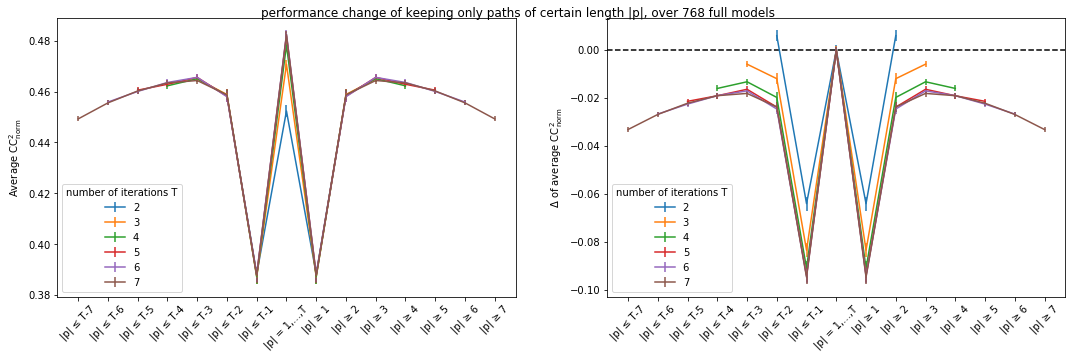

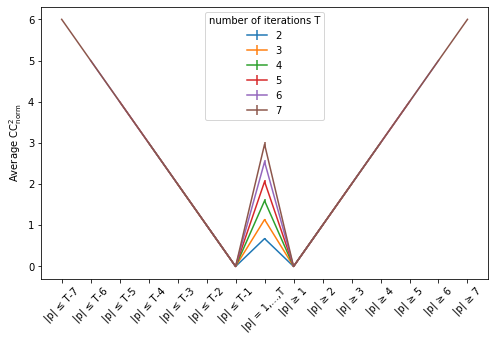

[0.4584261671396961, 0.38835785302151915, 0.38835785302151915, 0.4584261671396961, 0.46489111412655554, 0.45883491414819455, 0.3872893032187187, 0.3872893032187187, 0.45883491414819455, 0.46489111412655554, 0.4622414469751358, 0.4650247106200279, 0.45849902644731966, 0.38729577170744683, 0.38729577170744683, 0.45849902644731966, 0.4650247106200279, 0.4622414469751358, 0.4605212037165551, 0.46285013054012236, 0.46554194695897233, 0.45812196128554905, 0.3879727231664843, 0.3879727231664843, 0.45812196128554905, 0.46554194695897233, 0.46285013054012236, 0.4605212037165551, 0.45585760291090704, 0.46003635723688385, 0.46355717236411287, 0.46554992495636865, 0.4579757641236635, 0.3882115483426315, 0.3882115483426315, 0.4579757641236635, 0.46554992495636865, 0.46355717236411287, 0.46003635723688385, 0.45585760291090704, 0.449247211989501, 0.45554586274685716, 0.4602240416049086, 0.463373584213359, 0.4643196101335386, 0.45866875904999704, 0.3876756702184468, 0.3876756702184468, 0.4586687590499

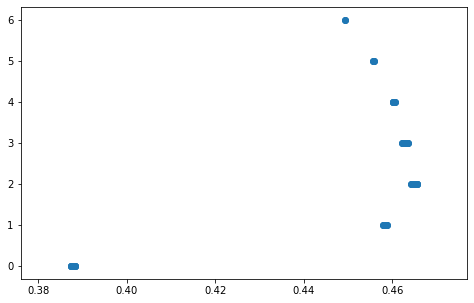

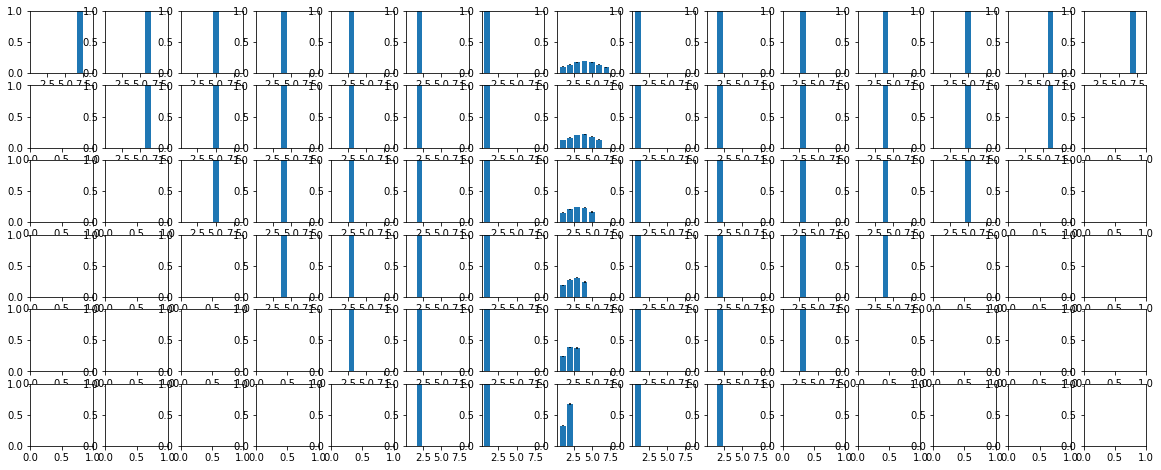

In [36]:
main_loop(df_main_result.join(df_src[['source_analysis_scalar','source_analysis_vec']],how='left',))